#### 데이터 로드

In [20]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('/content/drive/MyDrive/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/drive/MyDrive/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/drive/MyDrive/data/names/Italian.txt', '/content/drive/MyDrive/data/names/Japanese.txt', '/content/drive/MyDrive/data/names/Portuguese.txt', '/content/drive/MyDrive/data/names/Russian.txt', '/content/drive/MyDrive/data/names/Korean.txt', '/content/drive/MyDrive/data/names/Dutch.txt', '/content/drive/MyDrive/data/names/Chinese.txt', '/content/drive/MyDrive/data/names/Polish.txt', '/content/drive/MyDrive/data/names/Scottish.txt', '/content/drive/MyDrive/data/names/Greek.txt', '/content/drive/MyDrive/data/names/German.txt', '/content/drive/MyDrive/data/names/Czech.txt', '/content/drive/MyDrive/data/names/French.txt', '/content/drive/MyDrive/data/names/Arabic.txt', '/content/drive/MyDrive/data/names/English.txt', '/content/drive/MyDrive/data/names/Irish.txt', '/content/drive/MyDrive/data/names/Spanish.txt', '/content/drive/MyDrive/data/names/Vietnamese.txt']
Slusarski


#### 데이터 > 벡터 변환 과정

In [22]:
import torch

# 알파벳(대소문자)에서 letter의 인덱스 개수
def letterToIndex(letter):
    return all_letters.find(letter)

# index 위치를 텐서로 변환하는 과정, letterToTensor로 확인할 수 있다.
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 위의 함수를 문자열로 반복하는 과정으로 one-hot-vector와 유사하다고 할 수 있다. lineToTensor로 확인할 수 있다.
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


#### RNN model 로드

In [30]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [34]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8608, -2.9263, -2.9043, -2.8605, -2.9421, -2.9392, -2.9485, -2.7975,
         -2.8748, -2.9934, -2.8845, -2.8428, -2.8904, -2.8987, -2.9715, -2.8069,
         -2.8522, -2.8571]], grad_fn=<LogSoftmaxBackward0>)


## 카테고리 확인

In [35]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 7)


In [42]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Yanko
category = Dutch / line = Koning
category = German / line = Weeber
category = French / line = Proulx
category = Spanish / line = Moreno
category = Chinese / line = Zeng
category = Scottish / line = Wright
category = Arabic / line = Deeb
category = Korean / line = Yun
category = Russian / line = Yujanov


## Train

In [39]:
# loss
criterion = nn.NLLLoss()

1. NLLLoss는 crossentropy와 동작은 유사하나 마지막에 sottmax 함수를 추가해줘야 한다

In [40]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    # hidden state 초기화
    hidden = rnn.initHidden()
    # gradient 초기화
    rnn.zero_grad()
    # hidden state를 다음 단계로 전달
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    # 역전파 과정
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [43]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 3.2979 Ichiyusai / Polish ✗ (Japanese)
10000 10% (0m 15s) 2.2509 Amador / Portuguese ✗ (Spanish)
15000 15% (0m 22s) 0.8296 Yan / Chinese ✓
20000 20% (0m 30s) 8.3728 Bernard / French ✗ (Polish)
25000 25% (0m 37s) 2.8989 Kattan / Irish ✗ (Arabic)
30000 30% (0m 45s) 2.0857 Sabbagh / Irish ✗ (Arabic)
35000 35% (0m 53s) 1.2502 Beringer / German ✓
40000 40% (1m 1s) 0.0013 Nurtdinov / Russian ✓
45000 45% (1m 8s) 0.3014 Pinheiro / Portuguese ✓
50000 50% (1m 16s) 0.9136 Campbell / Scottish ✓
55000 55% (1m 27s) 2.6565 Charpentier / German ✗ (French)
60000 60% (1m 35s) 0.9641 Guerrero / Portuguese ✗ (Spanish)
65000 65% (1m 44s) 2.4291 O'Sullivan / Dutch ✗ (Irish)
70000 70% (1m 52s) 1.4918 Bitar / Scottish ✗ (Arabic)
75000 75% (2m 0s) 0.3979 Connell / Irish ✓
80000 80% (2m 9s) 0.9530 Schoorel / Dutch ✓
85000 85% (2m 16s) 6.2913 Schulthei / Vietnamese ✗ (German)
90000 90% (2m 25s) 1.4965 Reijnder / German ✗ (Dutch)
95000 95% (2m 32s) 0.6365 Geng / Chinese ✓
100000 100% (2m 40s) 0.24

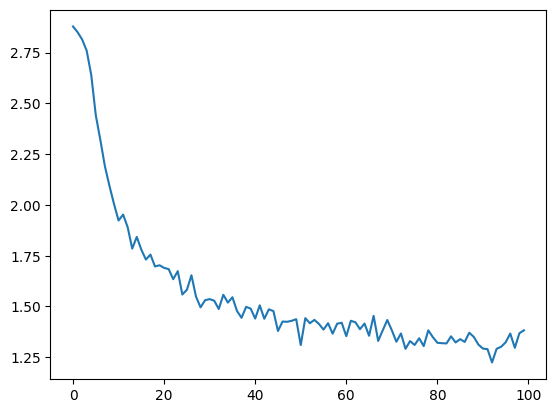

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [46]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [51]:
predict('chang')


> chang
(-1.27) Scottish
(-1.53) Korean
(-1.96) German


In [48]:
predict('jhon')


> jhon
(-1.44) Korean
(-1.58) English
(-2.03) Scottish
